In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Biotypes

Update gene biotypes for new FIB dataset where outlying cell was removed first, before gene filtering (mean threshold of 1)

Use Ensembl database to find gene type for each gene name / symbol:
- in the case where multiple type match the same name (as do not have unique identifier like ENSEMBL ID) take the majority type, but with priority for protein coding
- if no type exists report as a Failure (may be outdated / different naming convention)

## Load Data

In [59]:
# FIB counts: cells then genes filtered
data_FIB = pd.read_csv("../Data/GSE151334_FIB_counts_thresh.csv", index_col=0)
data_FIB.head()

,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P17_S377,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
7SK,18,3,6,8,35,0,0,21,9,9,...,10,61,23,19,5,3,23,15,1,14
A4GALT,0,0,0,0,0,0,0,0,0,28,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,0,0,0,0,0,3,4,...,0,0,0,0,0,0,5,0,0,0
AACS,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,4,55,22,42
AADAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load Ensembl Data

In [60]:
# Gene data
biotypes_new_df = pd.read_csv("./mart_export.txt")
biotypes_new_df.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene name,Transcript type,Gene type
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,MT-TF,Mt_tRNA,Mt_tRNA
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,MT-RNR1,Mt_rRNA,Mt_rRNA
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,MT-TV,Mt_tRNA,Mt_tRNA
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,MT-RNR2,Mt_rRNA,Mt_rRNA
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,MT-TL1,Mt_tRNA,Mt_tRNA


In [61]:
# Look only at gene name and type
biotypes_new_df = biotypes_new_df[['Gene name', 'Gene type']].drop_duplicates().dropna()
biotypes_new_df

,Gene name,Gene type
0,MT-TF,Mt_tRNA
1,MT-RNR1,Mt_rRNA
2,MT-TV,Mt_tRNA
3,MT-RNR2,Mt_rRNA
4,MT-TL1,Mt_tRNA
...,...,...
533440,TSPAN1,protein_coding
533467,AHCYL1,protein_coding
533480,JMJD4,protein_coding
533530,DAP3,protein_coding


In [62]:
# select data gene names
data_gene_names = list(data_FIB.index)

# for each gene name
data_gene_types = []
for name in tqdm.tqdm(data_gene_names):

    # select all associated gene types
    gene_types = biotypes_new_df[biotypes_new_df['Gene name'] == name]['Gene type']

    # no data
    if len(gene_types) == 0:
        data_gene_types.append("Failure")

    # unique type
    elif len(gene_types) == 1:
        data_gene_types.append(gene_types.iloc[0])

    # multiple types
    # protein coding priority
    elif "protein_coding" in gene_types:
        data_gene_types.append("protein_coding")

    # else majority
    else:
        data_gene_types.append(gene_types.value_counts().index[0])

100%|██████████| 11747/11747 [00:25<00:00, 453.16it/s]


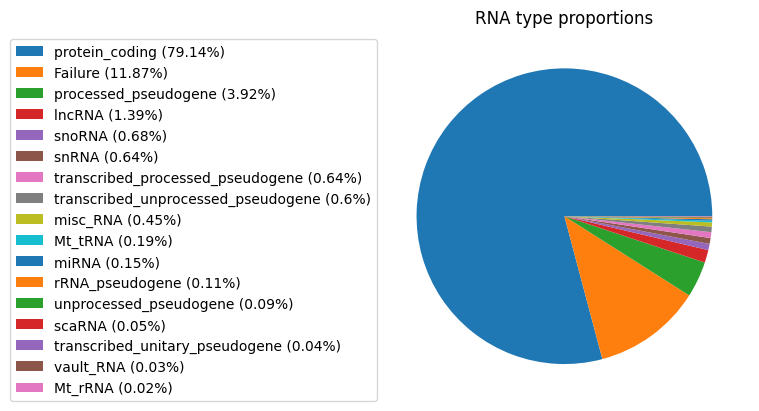

In [63]:
# display proportions of RNA types
types, counts = np.unique(data_gene_types, return_counts=True)
sort_idx = np.argsort(-counts)
types = types[sort_idx]
counts = counts[sort_idx]
plt.pie(counts)
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / data_FIB.shape[0], 2)}%)" for name, count in zip(types, counts)])
plt.title("RNA type proportions")
plt.show()

## Manual inspection

In [64]:
# look at genes with "MIR" in their names which do not have type miRNA
mi_names = [name for name in data_gene_names if "MIR" in name]
mi_types_not = []
mi_names_not = []
for name in mi_names:
    idx = list(data_gene_names).index(name)
    btype = data_gene_types[idx]
    if btype != "miRNA":
        mi_types_not.append(btype)
        mi_names_not.append(name)

In [65]:
# display
for name, btype in zip(mi_names_not, mi_types_not):
    print(f"{name} | {btype}")

MIR100HG | lncRNA
MIR155HG | lncRNA
MIR17HG | lncRNA
MIR222HG | lncRNA
MIR22HG | lncRNA
MIR4435-2HG | lncRNA
MIR4458HG | lncRNA
MIR503HG | lncRNA
MIR6087 | Failure
MIRLET7BHG | lncRNA


`MIR6087` is a microRNA which was set to 'Failure' as it was not present in Ensembl database, so manually update this

In [66]:
idx = data_gene_names.index("MIR6087")
data_gene_types[idx] = "miRNA"

Genes with the name `MIR...HG` are "microRNA non-coding host genes", long non-coding RNA which are also microRNA host genes.

Unsure how to treat these (as miRNA? as lncRNA?) so re-label as "miRNAHG" for now.

In [67]:
for name in mi_names_not:
    if name == "MIR6087": continue
    idx = data_gene_names.index(name)
    data_gene_types[idx] = "miRNAHG"

## Save Biotypes

In [68]:
# construct dictionary
biotypes_dict = {name: btype for name, btype in zip(data_gene_names, data_gene_types)}

In [73]:
# save
with open('biotypes_FIB.json', 'w') as f:
    json.dump(biotypes_dict, f)